** Vector Quantized Variational Autoencoders (VQ-VAE) **

We previously used continuous representations in our autoencoders, but this resulted in quite blurry reconstructions. In this notebook, we explore Vector Quantized Variational Autoencoders (VQ-VAE), a powerful generative model that learns discrete latent representations. Unlike standard VAEs that use continuous latent codes, VQ-VAE uses a codebook of discrete vectors, which is useful for learning interpretable and stable representations, but more importantly seem to generate sharper images.

We'll build a toy example to understand how VQ-VAE works.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from IPython import display
import numpy as np

In [2]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

data = torchvision.datasets.CIFAR10(root='./data/', transform=transform, train=True, download=False)
train_loader = DataLoader(data, batch_size=32, shuffle=True, num_workers=0)

Using device: cuda


/home/michael/Documents/Teaching/ECE4076/2026/ECE4076/ece4076_env/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


### The Vector Quantizer Layer

The key innovation in VQ-VAE is the **Vector Quantizer** (VQ) layer. This layer maps continuous encoder outputs to discrete codebook vectors. Here's how it works:

1. **Codebook**: We maintain a learnable codebook of K discrete vectors, each of dimension D.
2. **Quantization**: For each input vector, we find the nearest codebook vector (using L2 distance).
3. **Straight-through Estimator**: During backprop, we copy gradients from the decoder to the encoder (since argmin is not differentiable).

This creates a discrete bottleneck that forces the model to learn meaningful, interpretable representations.

In [3]:
class VectorQuantizer(nn.Module):
    """Vector Quantizer module for VQ-VAE"""

    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        """
        Args:
            num_embeddings: Size of the codebook (K)
            embedding_dim: Dimension of each codebook vector (D)
            commitment_cost: Scalar controlling the weighting of the loss terms
        """
        super(VectorQuantizer, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost

        # Initialize codebook
        self._embedding = nn.Embedding(num_embeddings, embedding_dim)
        self._embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (B, D, H, W)
        Returns:
            Quantized output, loss, and codes
        """
        # Flatten input
        x_flat = x.permute(0, 2, 3, 1).contiguous()
        x_flat = x_flat.view(-1, self._embedding_dim)

        # Calculate L2 distances between input and codebook vectors
        distances = (torch.sum(x_flat**2, dim=1, keepdim=True)
                    - 2 * torch.matmul(x_flat, self._embedding.weight.t())
                    + torch.sum(self._embedding.weight**2, dim=1))

        # Get the encoding indices
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self._num_embeddings).float()

        # Get quantized values
        quantized = torch.matmul(encodings, self._embedding.weight)
        quantized = quantized.view(x.shape[0], x.shape[2], x.shape[3], self._embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # VQ Loss: commitment loss + codebook loss
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        vq_loss = q_latent_loss + self._commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = x + (quantized - x).detach()

        # Reshape codes back to (B, H, W) for easier analysis/prior modeling
        codes = encoding_indices.view(x.shape[0], x.shape[2], x.shape[3])

        return quantized, vq_loss, codes

### VQ-VAE Architecture

Now let's build the complete VQ-VAE model with:
- **Encoder**: Compresses images to lower-dimensional feature maps
- **Vector Quantizer**: Maps continuous features to discrete codes
- **Decoder**: Reconstructs images from quantized features

In [4]:
class VQVAE(nn.Module):
    """Vector Quantized Variational Autoencoder"""

    def __init__(self, in_channels=3, latent_channels=64, num_embeddings=512, embedding_dim=64):
        super(VQVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        # Vector Quantizer
        self.vq = VectorQuantizer(num_embeddings, embedding_dim)

        # Projection from encoder to VQ space
        self.pre_quant_conv = nn.Conv2d(latent_channels, embedding_dim, kernel_size=1)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, latent_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(latent_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)

        # Project to embedding space
        z_e = self.pre_quant_conv(encoded)

        # Quantize
        z_q, vq_loss, codes = self.vq(z_e)

        # Decode
        recon = self.decoder(z_q)

        return recon, vq_loss, codes, z_e, z_q

In [5]:
# Initialize model
model = VQVAE(
    in_channels=3,
    latent_channels=128,
    num_embeddings=512,
    embedding_dim=128
).to(device)

print(f"Model moved to {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model moved to cuda
Total parameters: 611,523


### Training the VQ-VAE

The training objective combines:
1. **Reconstruction Loss**: L2 loss between original and reconstructed images
2. **VQ Loss**: Encourages the encoder output to stay close to the codebook vectors and the codebook to move toward encoder outputs

This forces the model to learn a discrete representation while maintaining reconstruction quality.

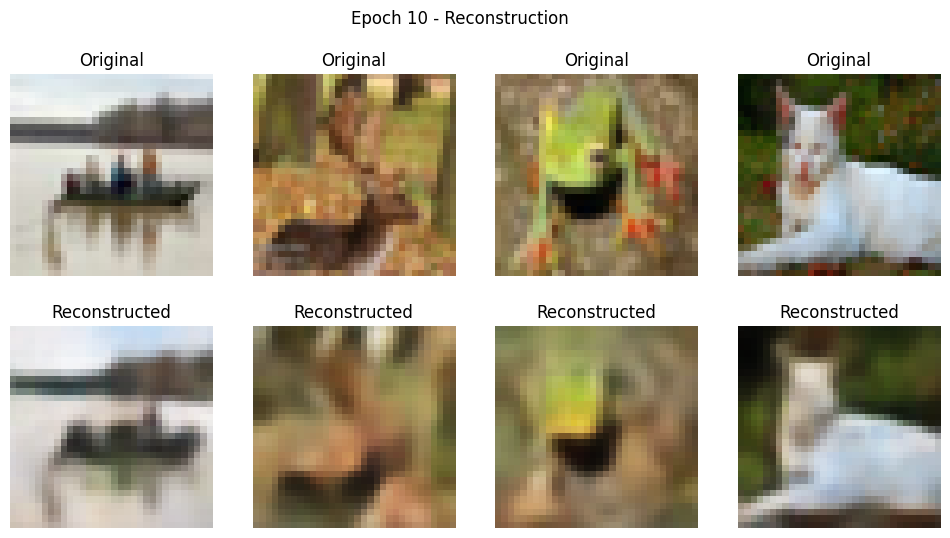

In [6]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10
avg_loss = None

for epoch in range(n_epochs):
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{n_epochs}")

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon, vq_loss, codes, z_e, z_q = model(x)

        # Reconstruction loss
        recon_loss = F.mse_loss(recon, x)

        # Total loss
        loss = recon_loss + vq_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update progress bar
        pbar.update(1)

        if avg_loss is None:
            avg_loss = loss.item()
        else:
            avg_loss = 0.95 * avg_loss + 0.05 * loss.item()

        pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'recon': f'{recon_loss:.4f}', 'vq': f'{vq_loss:.4f}'})

    pbar.close()

    # Visualization
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            fig, axes = plt.subplots(2, 4, figsize=(12, 6))
            for i in range(4):
                # Original
                axes[0, i].imshow(x[i].permute(1, 2, 0).cpu())
                axes[0, i].set_title('Original')
                axes[0, i].axis('off')

                # Reconstructed
                axes[1, i].imshow(recon[i].permute(1, 2, 0).cpu())
                axes[1, i].set_title('Reconstructed')
                axes[1, i].axis('off')

            plt.suptitle(f'Epoch {epoch+1} - Reconstruction')
            display.clear_output(wait=True)
            display.display(fig)
            plt.close()

### Exploring the Learned Codebook

Now let's examine what the model has learned. We can visualize the codebook vectors and see which codes are used most frequently in the dataset.

In [7]:
# Collect all codes used in the dataset
all_codes = []
model.eval()

with torch.no_grad():
    for x, _ in tqdm(train_loader, desc="Collecting codes"):
        x = x.to(device)
        _, _, codes, _, _ = model(x)          # codes: (B, H, W)
        all_codes.append(codes.cpu())

# Stack to (N, H, W)
all_codes = torch.cat(all_codes, dim=0)

# Analyze code usage
all_codes_flat = all_codes.reshape(-1)
unique_codes, counts = torch.unique(all_codes_flat, return_counts=True)

# % of embeddings that are used at least once
usage_percentage = (len(unique_codes) / model.vq._num_embeddings) * 100

print(f"Total number of codebook entries: {model.vq._num_embeddings}")
print(f"Number of unique codes used: {len(unique_codes)}")
print(f"Codebook usage (unique/total): {usage_percentage:.1f}%")
print(f"Most used codes: {unique_codes[torch.argsort(counts, descending=True)[:10]].tolist()}")
print(f"Their frequencies: {counts[torch.argsort(counts, descending=True)[:10]].tolist()}")


Total number of codebook entries: 512
Number of unique codes used: 89
Codebook usage (unique/total): 17.4%
Most used codes: [275, 127, 125, 434, 239, 256, 506, 92, 360, 89]
Their frequencies: [72909, 71233, 69553, 68487, 68056, 67646, 65693, 63823, 63645, 63421]


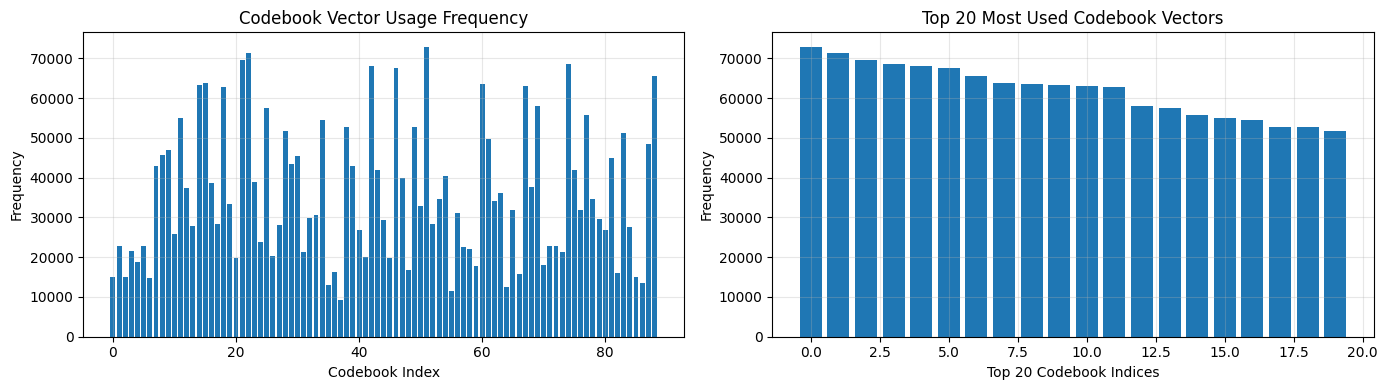

The model uses approximately 17.4% of the codebook.


In [8]:
# Plot code usage distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram of code usage
axes[0].bar(range(len(counts)), counts.numpy())
axes[0].set_xlabel('Codebook Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Codebook Vector Usage Frequency')
axes[0].grid(alpha=0.3)

# Top 20 most used codes
top_20_indices = torch.argsort(counts, descending=True)[:20]
top_20_counts = counts[top_20_indices]
axes[1].bar(range(20), top_20_counts.numpy())
axes[1].set_xlabel('Top 20 Codebook Indices')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 20 Most Used Codebook Vectors')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"The model uses approximately {(len(unique_codes) / model.vq._num_embeddings * 100):.1f}% of the codebook.")

### Final Reconstruction Quality

Let's evaluate the final reconstruction quality on a batch of test images.

Reconstruction L1 Loss: 0.052071
VQ Loss: 0.007397


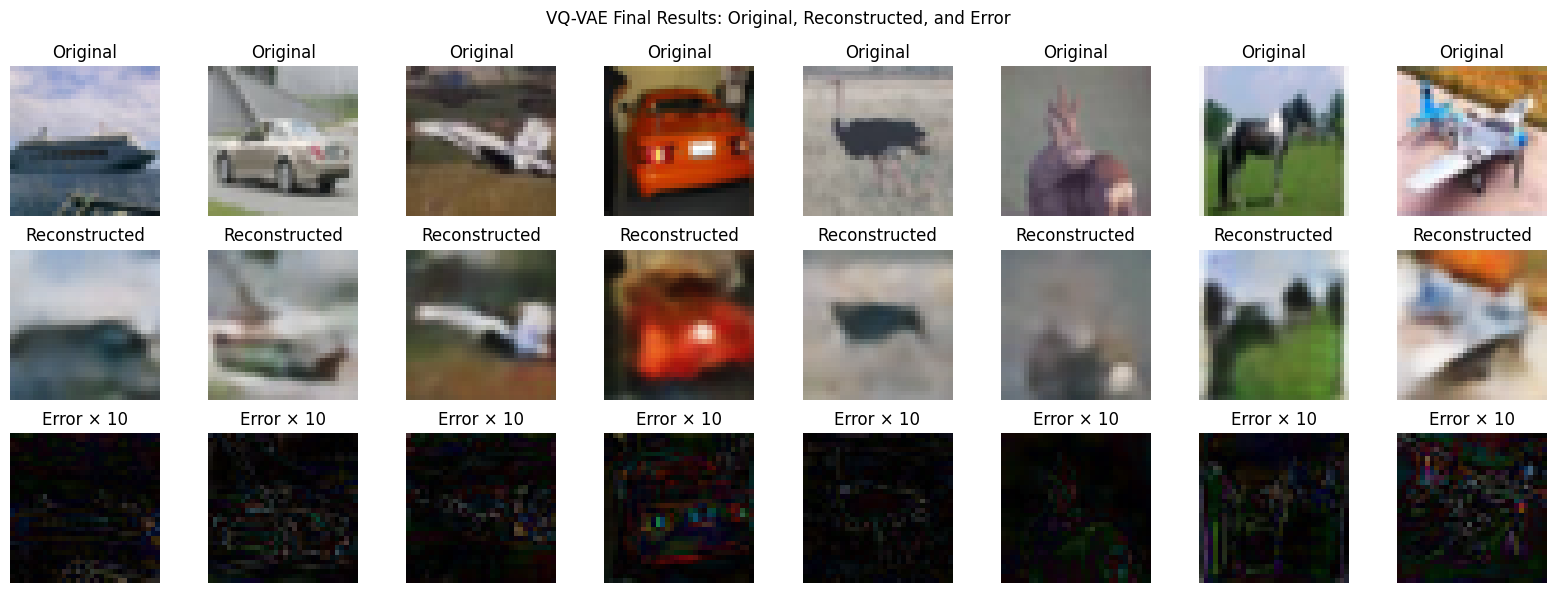

In [9]:
# Final evaluation
with torch.no_grad():
    # Get a test batch
    test_batch = next(iter(train_loader))[0].to(device)

    # Get reconstructions
    recon, vq_loss, codes, z_e, z_q = model(test_batch)

    # Calculate losses - use L1 for sharper images
    recon_loss = F.l1_loss(recon, test_batch).item()

    print(f"Reconstruction L1 Loss: {recon_loss:.6f}")
    print(f"VQ Loss: {vq_loss:.6f}")

    # Visualize
    fig, axes = plt.subplots(3, 8, figsize=(16, 6))
    for i in range(8):
        # Original
        axes[0, i].imshow(test_batch[i].permute(1, 2, 0).cpu())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Reconstructed
        axes[1, i].imshow(recon[i].permute(1, 2, 0).cpu())
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

        # Difference (amplified for visibility)
        diff = torch.abs(recon[i] - test_batch[i])
        axes[2, i].imshow(diff.permute(1, 2, 0).cpu())
        axes[2, i].set_title(f'Error × 10')
        axes[2, i].axis('off')

    plt.suptitle('VQ-VAE Final Results: Original, Reconstructed, and Error')
    plt.tight_layout()
    plt.show()

### Why Train a Prior Model?

The VQ-VAE encoder-decoder learns to **reconstruct** images, but it cannot **generate** novel ones. Here's why we need an autoregressive prior:

#### The Problem
- The VQ-VAE is trained only to minimize reconstruction loss on existing images
- Without guidance, sampling random codes from the codebook produces incoherent noise
- The model knows *what codes represent*, but not *which code sequences are likely to occur*

#### The Solution: Learn a Prior Distribution
By training an autoregressive model on the discrete codes:

1. **Learns Natural Code Patterns**: The prior discovers which code sequences naturally occur in real images (e.g., sky codes rarely follow detailed texture codes in CIFAR-10)
2. **Enables Generation**: We can sample codes from the prior's learned distribution, then decode them through the VQ-VAE decoder into plausible images
3. **Captures Structure**: The prior models the implicit statistical structure of the dataset—generated images follow learned patterns rather than being random

#### Simple Analogy
- **VQ-VAE**: Learns a visual "vocabulary" (how to encode/decode patterns)
- **Prior**: Learns the "grammar" (which sequences of patterns make sense together)

With both components, we can generate diverse, coherent images instead of noise.

In [10]:
class CodePrior(nn.Module):
    """Autoregressive prior model for generating discrete codes"""

    def __init__(self, num_embeddings, hidden_dim=256):
        super(CodePrior, self).__init__()
        self.num_embeddings = num_embeddings

        # Embedding layer for codes
        self.embedding = nn.Embedding(num_embeddings + 1, hidden_dim)  # +1 for start token

        # GRU for autoregressive modeling
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2)

        # Output projection
        self.fc = nn.Linear(hidden_dim, num_embeddings)

    def forward(self, codes):
        """
        Args:
            codes: (B, L) tensor of code indices
        Returns:
            logits: (B, L, num_embeddings) predictions
        """
        # Embed codes
        embedded = self.embedding(codes)

        # RNN forward pass
        rnn_out, _ = self.rnn(embedded)

        # Predict logits
        logits = self.fc(rnn_out)
        return logits


# Initialize prior model
prior_model = CodePrior(num_embeddings=512, hidden_dim=256).to(device)
prior_optimizer = torch.optim.Adam(prior_model.parameters(), lr=1e-3)

print(f"Prior model moved to {device}")
print(f"Prior total parameters: {sum(p.numel() for p in prior_model.parameters()):,}")

Prior model moved to cuda
Prior total parameters: 1,052,416


In [11]:
# Train the prior model on collected codes
# codes_for_prior: (N_images, L) where L = H*W (e.g., 8*8 = 64 for 32x32 inputs with 2 stride-2 downsamples)
codes_for_prior = all_codes.view(all_codes.shape[0], -1).long()

seq_len = codes_for_prior.shape[1]
print(f"Training prior on {codes_for_prior.shape[0]} code sequences...")
print(f"Sequence length (H*W): {seq_len}")

# We'll train with an explicit start token so the model learns to generate the first code.
start_idx = prior_model.num_embeddings  # index = num_embeddings (the +1 entry in the embedding table)

prior_epochs = 5
prior_model.train()

batch_size = 32

for epoch in range(prior_epochs):
    total_loss = 0
    num_batches = 0

    pbar = tqdm(total=len(codes_for_prior), desc=f"Prior Epoch {epoch+1}/{prior_epochs}")

    for i in range(0, len(codes_for_prior), batch_size):
        target_codes = codes_for_prior[i:i+batch_size].to(device)  # (B, L)

        # Skip batches that are too small
        if target_codes.shape[0] < 2 or target_codes.shape[1] < 2:
            pbar.update(min(batch_size, len(codes_for_prior) - i))
            continue

        # Inputs are [START] + codes[:-1]; targets are codes
        start_tokens = torch.full((target_codes.shape[0], 1), start_idx, dtype=torch.long, device=device)
        input_codes = torch.cat([start_tokens, target_codes[:, :-1]], dim=1)  # (B, L)

        prior_optimizer.zero_grad()

        logits = prior_model(input_codes)  # (B, L, num_embeddings)

        # Cross-entropy loss over codebook indices (0..num_embeddings-1)
        loss = F.cross_entropy(logits.reshape(-1, prior_model.num_embeddings),
                               target_codes.reshape(-1))

        loss.backward()
        prior_optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        pbar.update(min(batch_size, len(codes_for_prior) - i))

    pbar.close()
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"Prior Loss: {avg_loss:.4f}")


Training prior on 50000 code sequences...
Sequence length (H*W): 64


Prior Epoch 1/5:   0%|          | 0/50000 [00:00<?, ?it/s]

Prior Loss: 3.4398


Prior Epoch 2/5:   0%|          | 0/50000 [00:00<?, ?it/s]

Prior Loss: 3.3071


Prior Epoch 3/5:   0%|          | 0/50000 [00:00<?, ?it/s]

Prior Loss: 3.2768


Prior Epoch 4/5:   0%|          | 0/50000 [00:00<?, ?it/s]

Prior Loss: 3.2582


Prior Epoch 5/5:   0%|          | 0/50000 [00:00<?, ?it/s]

Prior Loss: 3.2444


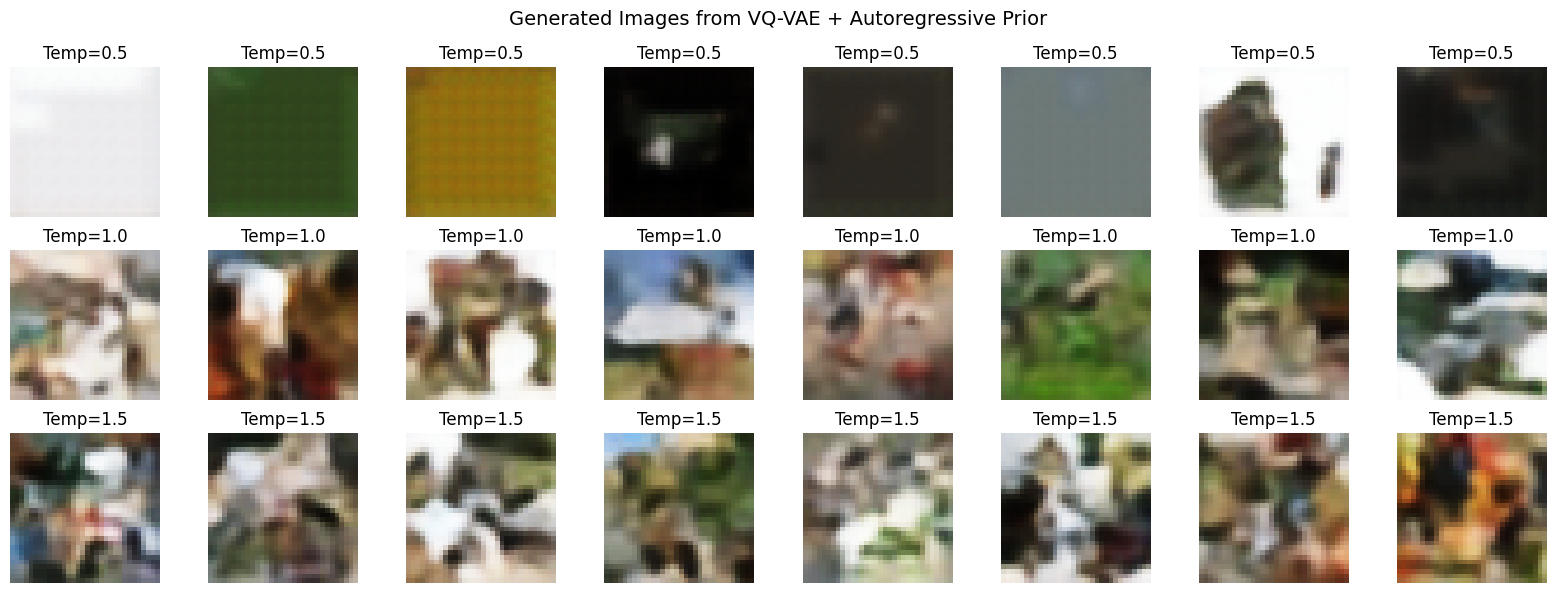

Generation complete! Different temperatures show different levels of diversity.
Lower temperature (0.5) = more conservative, Higher temperature (1.5) = more diverse


In [12]:
def generate_images(model, prior, num_samples=8, device='cpu', temperature=1.0, seq_len=None):
    """
    Generate new images by autoregressive sampling from the prior

    Args:
        model: Trained VQ-VAE model
        prior: Trained prior model
        num_samples: Number of images to generate
        device: Device to use
        temperature: Controls randomness (higher = more random)
        seq_len: Number of codes to generate (defaults to codes_for_prior.shape[1] if available)
    """
    model.eval()
    prior.eval()

    # Determine sequence length (H*W)
    if seq_len is None:
        if 'codes_for_prior' in globals():
            seq_len = codes_for_prior.shape[1]
        else:
            # Fall back to 8x8 for 32x32 inputs with two stride-2 downsamples
            seq_len = 64

    # Infer latent grid size (assumes square grid)
    latent_hw = int(seq_len ** 0.5)
    assert latent_hw * latent_hw == seq_len, f"seq_len={seq_len} is not a perfect square; can't infer (H, W)."
    latent_h = latent_w = latent_hw

    with torch.no_grad():
        # Start with start token (index = num_embeddings)
        start_token = torch.full((num_samples, 1), prior.num_embeddings, dtype=torch.long, device=device)
        generated = start_token

        # Autoregressive generation: generate seq_len codes total
        for _ in range(seq_len):
            logits = prior(generated)                 # (B, T, num_embeddings)
            next_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_logits, dim=-1)
            next_code = torch.multinomial(probs, num_samples=1)  # (B, 1)
            generated = torch.cat([generated, next_code], dim=1)

        # Remove start token - keep only generated codes
        generated_codes = generated[:, 1:]  # (B, seq_len)
        assert generated_codes.shape == (num_samples, seq_len)

        # Decode codes to images using VQ-VAE decoder
        # Map indices -> embeddings then reshape to (B, D, H, W)
        z_q = model.vq._embedding(generated_codes.reshape(-1))  # (B*seq_len, D)
        z_q = z_q.view(num_samples, latent_h, latent_w, model.vq._embedding_dim).permute(0, 3, 1, 2).contiguous()

        generated_images = model.decoder(z_q)

    return generated_images, generated_codes


# Generate samples with different temperatures
temperatures = [0.5, 1.0, 1.5]
fig, axes = plt.subplots(len(temperatures), 8, figsize=(16, 6))

for temp_idx, temp in enumerate(temperatures):
    gen_images, gen_codes = generate_images(model, prior_model, num_samples=8,
                                            device=device, temperature=temp)

    for i in range(8):
        axes[temp_idx, i].imshow(gen_images[i].permute(1, 2, 0).cpu())
        axes[temp_idx, i].set_title(f'Temp={temp}')
        axes[temp_idx, i].axis('off')

plt.suptitle('Generated Images from VQ-VAE + Autoregressive Prior', fontsize=14)
plt.tight_layout()
plt.show()

print("Generation complete! Different temperatures show different levels of diversity.")
print("Lower temperature (0.5) = more conservative, Higher temperature (1.5) = more diverse")


### Summary

In this notebook, we've implemented a VQ-VAE and trained it on CIFAR-10. Key takeaways:

1. **Discrete Latent Space**: VQ-VAE forces the model to use discrete codebook vectors instead of continuous latent codes.
2. **Vector Quantization Loss**: This loss term ensures the encoder outputs stay close to codebook vectors, and the codebook learns to represent common patterns.
3. **Straight-through Estimator**: We use a trick to backpropagate through the discrete bottleneck.
4. **Interpretability**: The discrete codes make the model more interpretable - we can see exactly which codebook patterns are used.
5. **Generation**: We need to train a separate prior on the codebooks to generate new images.

VQ-VAE has been successfully applied to image generation, video prediction, and speech synthesis. The discrete bottleneck makes it particularly useful for hierarchical generative models!